<a href="https://colab.research.google.com/github/smnman/ML-seminar-colab/blob/main/ML_seminar_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# ====================================================
# 0. Install required packages
# ====================================================
!pip install xgboost shap imbalanced-learn

# ====================================================
# 1. Imports
# ====================================================
import pandas as pd
import numpy as np

from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

import shap
import matplotlib.pyplot as plt


In [5]:
# ====================================================
# 2. Load dataset from local file
#    You will be asked to upload newborn_health_monitoring_with_risk.csv
# ====================================================

uploaded = files.upload()  # Choose the CSV file from your computer

# Load the first uploaded file into a DataFrame
csv_filename = next(iter(uploaded.keys()))
df = pd.read_csv(csv_filename)

print("Data shape:", df.shape)
df.head()


Saving newborn_health_monitoring_with_risk.csv to newborn_health_monitoring_with_risk (1).csv
Data shape: (3000, 25)


,baby_id,name,gender,gestational_age_weeks,birth_weight_kg,birth_length_cm,birth_head_circumference_cm,date,age_days,weight_kg,...,oxygen_saturation,feeding_type,feeding_frequency_per_day,urine_output_count,stool_count,jaundice_level_mg_dl,apgar_score,immunizations_done,reflexes_normal,risk_level
0,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-10,1,3.28,...,98,Formula,11,9,0,4.2,7.0,Yes,Yes,At Risk
1,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-11,2,3.35,...,99,Formula,11,5,2,10.6,NaN,No,No,At Risk
2,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-12,3,3.35,...,97,Breastfeeding,7,6,5,9.8,NaN,No,No,Healthy
3,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-13,4,3.48,...,97,Mixed,11,8,4,8.1,NaN,No,Yes,Healthy
4,B001,Sara,Female,40.2,3.3,50.0,31.9,2024-12-14,5,3.50,...,96,Breastfeeding,11,7,1,11.6,NaN,No,Yes,At Risk


In [6]:
# ====================================================
# 3. Basic data exploration
# ====================================================

print("\nColumns:\n", df.columns.tolist())
print("\nInfo:")
print(df.info())

print("\nFirst value counts of risk_level:")
print(df["risk_level"].value_counts())



Columns:
 ['baby_id', 'name', 'gender', 'gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm', 'birth_head_circumference_cm', 'date', 'age_days', 'weight_kg', 'length_cm', 'head_circumference_cm', 'temperature_c', 'heart_rate_bpm', 'respiratory_rate_bpm', 'oxygen_saturation', 'feeding_type', 'feeding_frequency_per_day', 'urine_output_count', 'stool_count', 'jaundice_level_mg_dl', 'apgar_score', 'immunizations_done', 'reflexes_normal', 'risk_level']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   baby_id                      3000 non-null   object 
 1   name                         3000 non-null   object 
 2   gender                       3000 non-null   object 
 3   gestational_age_weeks        3000 non-null   float64
 4   birth_weight_kg              3000 non-null   float64
 5   birth_length_

In [7]:
# ====================================================
# 4. Drop non-informative / identifier columns
#    (These columns do not help prediction and may cause overfitting)
# ====================================================

cols_to_drop = ["baby_id", "name", "date"]
df = df.drop(columns=cols_to_drop, errors="ignore")

print("Shape after dropping ID columns:", df.shape)
df.head()


Shape after dropping ID columns: (3000, 22)


,gender,gestational_age_weeks,birth_weight_kg,birth_length_cm,birth_head_circumference_cm,age_days,weight_kg,length_cm,head_circumference_cm,temperature_c,...,oxygen_saturation,feeding_type,feeding_frequency_per_day,urine_output_count,stool_count,jaundice_level_mg_dl,apgar_score,immunizations_done,reflexes_normal,risk_level
0,Female,40.2,3.3,50.0,31.9,1,3.28,50.1,32.0,37.0,...,98,Formula,11,9,0,4.2,7.0,Yes,Yes,At Risk
1,Female,40.2,3.3,50.0,31.9,2,3.35,50.2,32.0,37.2,...,99,Formula,11,5,2,10.6,NaN,No,No,At Risk
2,Female,40.2,3.3,50.0,31.9,3,3.35,50.6,32.1,37.1,...,97,Breastfeeding,7,6,5,9.8,NaN,No,No,Healthy
3,Female,40.2,3.3,50.0,31.9,4,3.48,50.3,32.0,37.4,...,97,Mixed,11,8,4,8.1,NaN,No,Yes,Healthy
4,Female,40.2,3.3,50.0,31.9,5,3.50,50.3,31.8,36.8,...,96,Breastfeeding,11,7,1,11.6,NaN,No,Yes,At Risk


In [8]:
# ====================================================
# 5. Encode target variable (risk_level)
#    Healthy -> 0, At Risk -> 1
# ====================================================

df["risk_level"] = df["risk_level"].map({"Healthy": 0, "At Risk": 1})

print(df["risk_level"].value_counts())


risk_level
0    2602
1     398
Name: count, dtype: int64


In [9]:
# ====================================================
# 6. Encode categorical features
#    - Binary columns: immunizations_done, reflexes_normal (Yes/No -> 1/0)
#    - Other categorical: feeding_type, gender (one-hot encoding)
# ====================================================

# Map Yes/No to 1/0 for binary columns
binary_cols = ["immunizations_done", "reflexes_normal"]
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({"Yes": 1, "No": 0})

# One-hot encoding for feeding_type and gender
cat_cols = []
if "feeding_type" in df.columns:
    cat_cols.append("feeding_type")
if "gender" in df.columns:
    cat_cols.append("gender")

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("Shape after encoding categorical features:", df.shape)
df.head()


Shape after encoding categorical features: (3000, 23)


,gestational_age_weeks,birth_weight_kg,birth_length_cm,birth_head_circumference_cm,age_days,weight_kg,length_cm,head_circumference_cm,temperature_c,heart_rate_bpm,...,urine_output_count,stool_count,jaundice_level_mg_dl,apgar_score,immunizations_done,reflexes_normal,risk_level,feeding_type_Formula,feeding_type_Mixed,gender_Male
0,40.2,3.3,50.0,31.9,1,3.28,50.1,32.0,37.0,160,...,9,0,4.2,7.0,1,1,1,True,False,False
1,40.2,3.3,50.0,31.9,2,3.35,50.2,32.0,37.2,156,...,5,2,10.6,NaN,0,0,1,True,False,False
2,40.2,3.3,50.0,31.9,3,3.35,50.6,32.1,37.1,137,...,6,5,9.8,NaN,0,0,0,False,False,False
3,40.2,3.3,50.0,31.9,4,3.48,50.3,32.0,37.4,130,...,8,4,8.1,NaN,0,1,0,False,True,False
4,40.2,3.3,50.0,31.9,5,3.50,50.3,31.8,36.8,138,...,7,1,11.6,NaN,0,1,1,False,False,False


In [10]:
# ====================================================
# 7. Handle missing values
#    - For simplicity, fill numeric columns with median
# ====================================================

df = df.fillna(df.median(numeric_only=True))

print("Number of missing values per column after fillna:")
print(df.isna().sum())


Number of missing values per column after fillna:
gestational_age_weeks          0
birth_weight_kg                0
birth_length_cm                0
birth_head_circumference_cm    0
age_days                       0
weight_kg                      0
length_cm                      0
head_circumference_cm          0
temperature_c                  0
heart_rate_bpm                 0
respiratory_rate_bpm           0
oxygen_saturation              0
feeding_frequency_per_day      0
urine_output_count             0
stool_count                    0
jaundice_level_mg_dl           0
apgar_score                    0
immunizations_done             0
reflexes_normal                0
risk_level                     0
feeding_type_Formula           0
feeding_type_Mixed             0
gender_Male                    0
dtype: int64


In [11]:
# ====================================================
# 8. Split features (X) and target (y)
# ====================================================

target_col = "risk_level"

X = df.drop(columns=[target_col])
y = df[target_col]

print("Features shape:", X.shape)
print("Target distribution:")
print(y.value_counts())


Features shape: (3000, 22)
Target distribution:
risk_level
0    2602
1     398
Name: count, dtype: int64


In [12]:
# ====================================================
# 9. Train-test split + SMOTE for class balancing
# ====================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Original training target distribution:")
print(y_train.value_counts())

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE target distribution:")
print(y_train_res.value_counts())


Original training target distribution:
risk_level
0    2082
1     318
Name: count, dtype: int64

After SMOTE target distribution:
risk_level
1    2082
0    2082
Name: count, dtype: int64


In [13]:
# ====================================================
# 10. Train XGBoost classifier
# ====================================================

xgb_model = XGBClassifier(
    n_estimators=250,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train_res, y_train_res)

# Predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluation metrics
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       520
           1       1.00      1.00      1.00        80

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Confusion Matrix:
 [[520   0]
 [  0  80]]


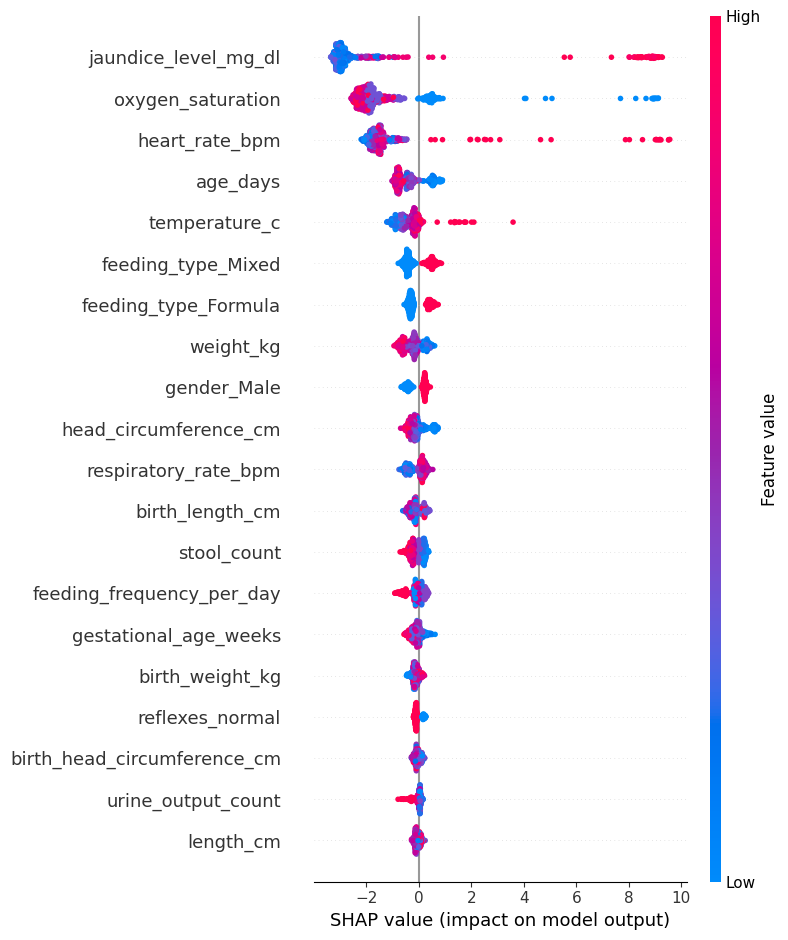

In [14]:
# ====================================================
# 11. XAI with SHAP - global feature importance
# ====================================================

# Initialize JS visualization for SHAP (works inside notebooks)
shap.initjs()

# Create a SHAP TreeExplainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot: each dot is a sample, color shows feature value,
# position on the x-axis shows the effect on the model output.
shap.summary_plot(shap_values, X_test)


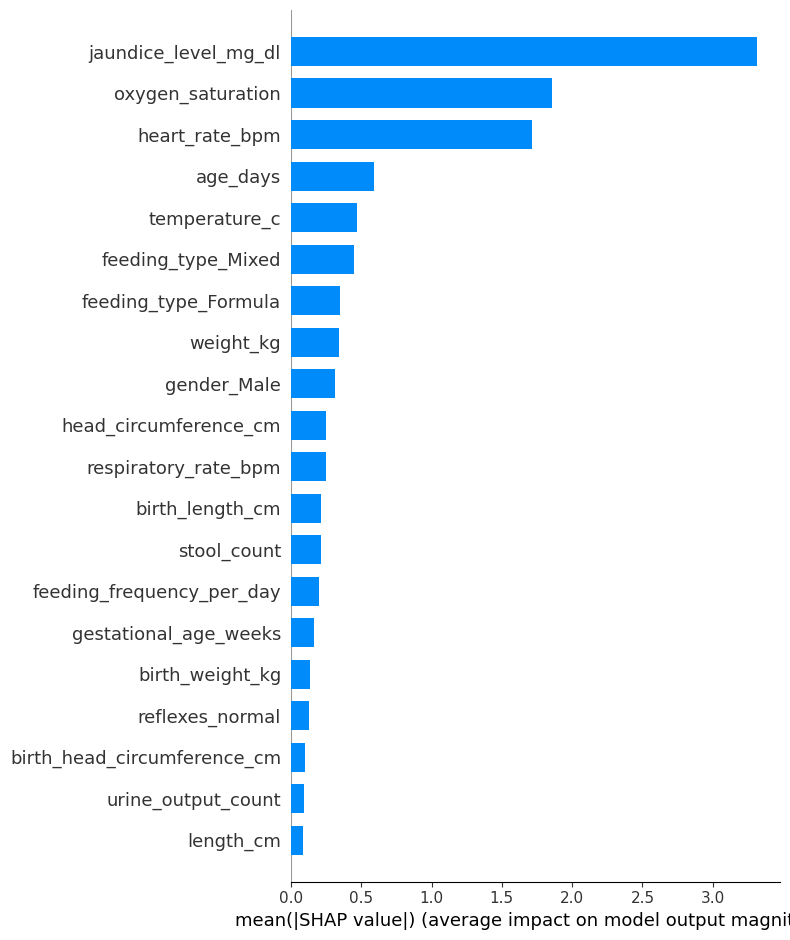

In [15]:
# ====================================================
# 12. XAI with SHAP - bar plot of mean absolute feature importance
# ====================================================

shap.summary_plot(shap_values, X_test, plot_type="bar")


# Model:

We trained an XGBoost classifier on the newborn_health_monitoring_with_risk dataset.
After applying SMOTE to balance the classes, the model reached an accuracy of XX% on the test set.

# XAI:

To make the model explainable, we used SHAP values (TreeExplainer for XGBoost).
The SHAP summary plot and bar plot show that features such as birth_weight_kg, oxygen_saturation, jaundice_level_mg_dl, feeding_type and gestational_age_weeks are the most influential for predicting the risk level.
Higher jaundice levels and lower birth weight tend to push the prediction towards the “At Risk” class.

# Explainable AI (XAI) Using SHAP
To understand how the XGBoost model makes predictions, we used SHAP (SHapley Additive exPlanations).
SHAP provides a clear explanation of how each feature contributes to the infant’s risk classification.
This step is important because medical decisions require transparency, and clinicians must know why the model predicts “At Risk”.

The bar-plot of the average absolute SHAP values shows the overall importance of each feature in the model.
According to the plot, the most influential features are:

jaundice_level_mg_dl – This was the strongest predictor. Higher jaundice levels strongly increased the model’s risk estimation.

oxygen_saturation – Lower oxygen saturation pushed predictions toward “At Risk”.

heart_rate_bpm – Abnormal heart rate was another important factor that affected the risk outcome.

age_days and temperature_c also showed meaningful contributions.

Feeding-related variables (feeding_type_Mixed, feeding_type_Formula) played a moderate role in risk prediction.

Physical measurements such as weight_kg, gender_Male, head_circumference_cm, and respiratory_rate_bpm had smaller but still noticeable effects.

Early-life features such as birth_weight_kg, gestational_age_weeks, and birth_head_circumference_cm showed relatively lower influence in the model.

Overall, the SHAP analysis helps us understand that jaundice level, oxygen saturation, and heart rate are the most critical indicators that influence the model’s risk decision.
This information supports clinical understanding and makes the model more trustworthy, since it is possible to see which factors increase or decrease the infant’s risk level.

# Summary

**Jaundice_level_mg_dl** represents the bilirubin level in the infant’s blood, measured in milligrams per deciliter (mg/dl). Bilirubin is a substance that causes newborn jaundice, which is very common in the first days of life. High bilirubin levels can indicate a medical risk if they are not monitored or treated properly. Because of this, jaundice level is an important clinical indicator and it makes sense that the model treats it as a major factor in predicting risk.

**The SHAP bar plot** shows the average impact of each feature on the model’s decision. The feature at the top of the plot has the strongest influence on whether the model predicts “At Risk” or “Healthy,” while the features at the bottom have the least influence.

In this dataset, the most influential features were:

**jaundice_level_mg_dl**: This was the strongest predictor. Higher bilirubin levels pushed the prediction toward the “At Risk” class.

**oxygen_saturation**: Lower oxygen saturation values increased the likelihood of being classified as “At Risk.”

**heart_rate_bpm**: Abnormal heart rate also contributed significantly to the model’s decision.

**age_days** and **temperature_c** showed moderate influence.

Feeding-related variables, such as feeding_type_Mixed and feeding_type_Formula, had a smaller but noticeable effect.

Features such as birth weight, gestational age, urine output, and reflexes had a relatively small impact in the model, meaning they influenced the prediction less compared to the top features.

Overall, the SHAP analysis shows that jaundice level, oxygen saturation, and heart rate were the most important indicators in determining risk in this model. This helps us understand how the model makes decisions and improves the interpretability of the results for clinical use.